<a href="https://colab.research.google.com/github/jajapuramshivasai/projects_24/blob/main/q24_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:

def sine_wave(U,wave_freq,wave_num_x,wave_num_y,t):
  l = len(U[0])
  omega = np.pi*wave_freq
  kx = (wave_num_x/(l-1))*np.pi
  ky = (wave_num_y/(l-1))*np.pi

  for i in range(l):
    for j in range(l):
      U[i][j] = np.sin(kx*i)*np.sin(ky*j)*np.cos(omega*t)
  return U

def gen_U(U,params,t):

  for param in params:
    U += sine_wave(U,param[0],param[1],param[2],t)
  return U/len(params)

In [3]:
params = [
    [1,2,2],
    [0.5,1,3],
    [0.25,2,4]
]

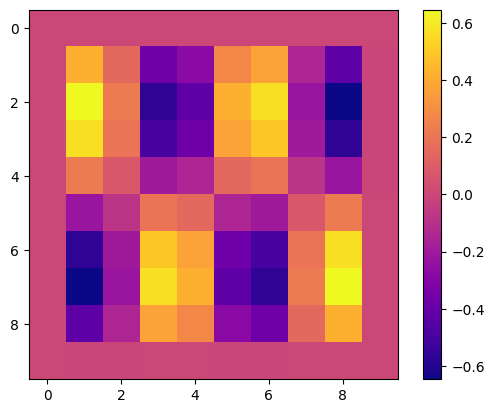

In [4]:
U = np.zeros((10,10))

U_ = gen_U(U,params,0)


plt.imshow(U_, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()


In [5]:
len([[1,2]])

1

Text(0.5, 0.92, 'Time step: 1')

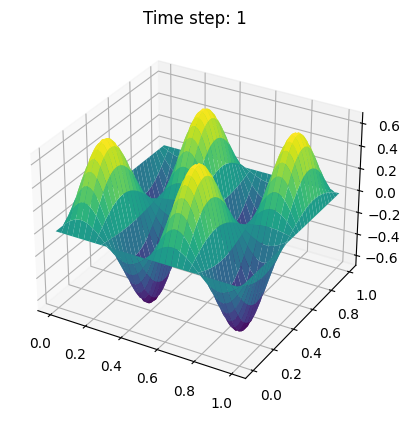

In [7]:
# Simulation parameters
Lx = 1.0  # Length of the domain in x
Ly = 1.0  # Length of the domain in y
T = 0.6   # Total time
c = 1.0   # Wave speed
Nx = 63    # Number of spatial grid points in x
Ny = 63   # Number of spatial grid points in y
Nt = 10    # Number of time steps
dx = Lx / Nx
dy = Ly / Ny
dt = T / Nt
rx = c * dt / dx
ry = c * dt / dy

# Spatial grid
x = np.linspace(0, Lx, Nx + 1)
y = np.linspace(0, Ly, Ny + 1)
X, Y = np.meshgrid(x, y)

# # Initial conditions (example: Gaussian pulse)
# def initial_condition(x, y):
#     center_x, center_y = Lx / 2, Ly / 2
#     width = 0.1
#     return np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * width**2))

# u0 = initial_condition(X, Y)
# u1 = initial_condition(X, Y)  # Assuming no change in the first time step

U = np.zeros((Nx+1,Ny+1))
U0 = gen_U(U,params,0)
U1 = gen_U(U,params,dt)

u0 = U0
u1 = U1

# Create the 2D Laplacian matrix (using a 5-point stencil)
A = np.zeros(((Nx + 1) * (Ny + 1), (Nx + 1) * (Ny + 1)))
for i in range(1, Nx):
    for j in range(1, Ny):
        index = i * (Ny + 1) + j
        A[index, index] = 1 + 2 * rx**2 + 2 * ry**2
        A[index, index - (Ny + 1)] = -rx**2
        A[index, index + (Ny + 1)] = -rx**2
        A[index, index - 1] = -ry**2
        A[index, index + 1] = -ry**2

# Boundary conditions (assuming Dirichlet boundary conditions)
# Set the boundary elements of A to 1 (identity)
for i in [0, Nx]:
    for j in range(Ny + 1):
        index = i * (Ny + 1) + j
        A[index, index] = 1
for j in [0, Ny]:
    for i in range(Nx + 1):
        index = i * (Ny + 1) + j
        A[index, index] = 1

#key step for HHL

A_symmetric = ( np.transpose(A) + A )/2

# Time stepping


u = np.zeros((Nt + 1, (Nx + 1) * (Ny + 1)))
u[0, :] = u0.flatten()
u[1, :] = u1.flatten()

for n in range(1, Nt):
    b = 2 * u[n] - u[n - 1]

    # Apply boundary conditions to the right-hand side |b>

        # Apply Dirichlet boundary conditions

    b[:Ny+1] = 0  # Bottom boundary
    b[Nx*(Ny+1):] = 0  # Top boundary
    b[::Ny+1] = 0  # Left boundary
    b[Ny::Ny+1] = 0  # Right boundary

    # Solve for the next time step
    u[n + 1, :] = np.linalg.solve(A, b)

# Reshape the solution back to a 2D grid for visualization
u_2d = u.reshape((Nt + 1, Nx + 1, Ny + 1))

# Visualization (example: animating the solution)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# def animate(i):
#     ax.clear()
ax.plot_surface(X, Y, u_2d[1], cmap='viridis')
ax.set_title(f"Time step: {1}")

# ani = animation.FuncAnimation(fig, animate, frames=Nt + 1, interval=200)
# plt.show()
# print(b)

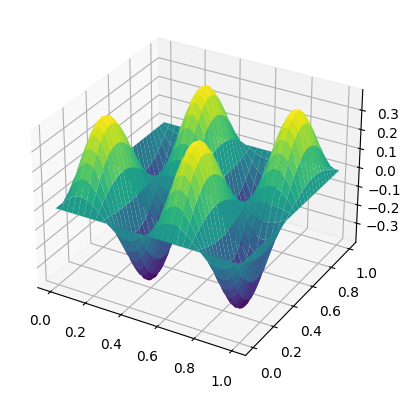

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_2d[2], cmap='viridis')

plt.show()

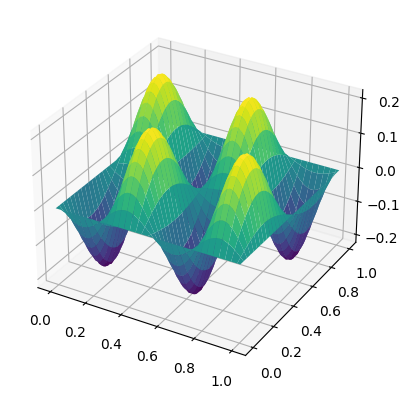

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_2d[5], cmap='viridis')

plt.show()

[[ 2. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  2.]]


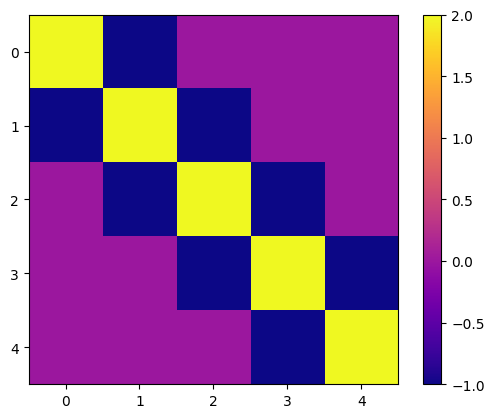

In [36]:
import numpy as np

def create_custom_diagonal_matrix(n, diagonals):
    """
    Creates a custom diagonal matrix for the implicit finite difference method.

    Parameters:
    n (int): The dimension of the matrix (number of grid points).
    diagonals (list of tuples): A list of tuples where each tuple contains the diagonal position
                                (relative to the main diagonal) and the coefficient for that diagonal.
                                For example, [(0, 2.0), (-1, -1.0), (1, -1.0)] means the main diagonal
                                has 2.0, the sub-diagonal has -1.0, and the super-diagonal has -1.0.

    Returns:
    np.ndarray: Custom diagonal matrix of dimension (n x n).
    """
    # Initialize an empty matrix
    A = np.zeros((n, n))

    # Fill the matrix with the given diagonal values
    for position, value in diagonals:
        diag_values = np.full(n - abs(position), value)
        A += np.diag(diag_values, k=position)

    return A

# Example usage
n = 5  # Dimension of the matrix
diagonals = [
    (0, 2.0),   # Main diagonal
    (-1, -1.0), # Sub-diagonal
    (1, -1.0)   # Super-diagonal
]

A = create_custom_diagonal_matrix(n, diagonals)
print(A)


plt.imshow(A, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

In [54]:
def prep_diag(dimension,length,r):
  diagonals= [
      (0,2*dimension*r**2+1)
  ]
  for i in range(1,dimension+1):
    k=length**(i-1)
    diagonals.append((-k, -r**2))
    diagonals.append((k, -r**2))
  return diagonals

D = prep_diag(2,5,1)
print(D)
D_ = create_custom_diagonal_matrix((5+1)**2,D)

[(0, 5), (-1, -1), (1, -1), (-5, -1), (5, -1)]


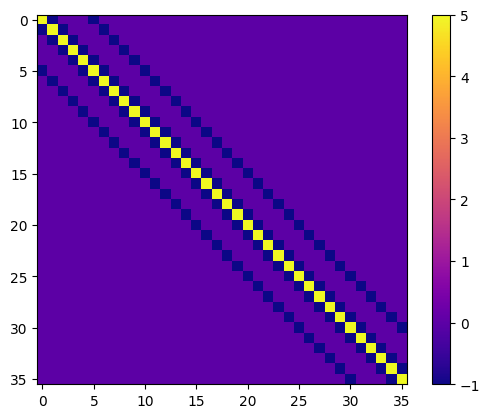

In [55]:

plt.imshow(D_, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
def gen_A(U,params,t):

  for param in params:
    U += sine_wave(U,param[0],param[1],param[2],t)
  return U/len(params)

In [ ]:
# Define x, y, z lists for sphere
a = linspace(0, 2 * pi)
b = linspace(0, pi)
x = 10 * outer(cos(a), sin(b))
y = 10 * outer(sin(a), sin(b))
z = 10 * outer(ones(size(a)), cos(b))

# The amount of frames in the animation
frames = 26

# Generate each frame
for n in range(frames):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, color=('b'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlim(-8,8)
    ax.set_xlim(-8,8)
    ax.set_xlim(-8,8)
    plt.savefig(f"{n}.png")
    plt.close()

    # Add 1 to the x so the sphere moves right by 1
    x += 1

# Use pillow to save all frames as an animation in a gif file
from PIL import Image

images = [Image.open(f"{n}.png") for n in range(frames)]

images[0].save('ball.gif', save_all=True, append_images=images[1:], duration=100, loop=0)

In [15]:
np.set_printoptions(threshold=np.inf)

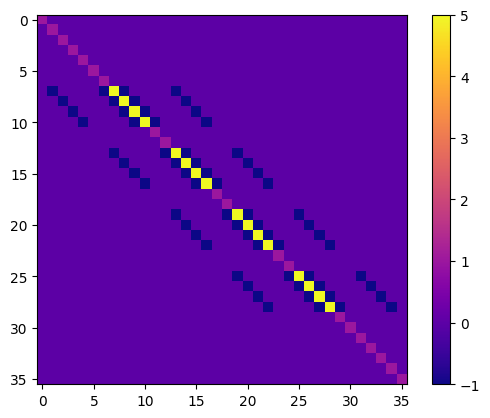

In [27]:
plt.imshow(A, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

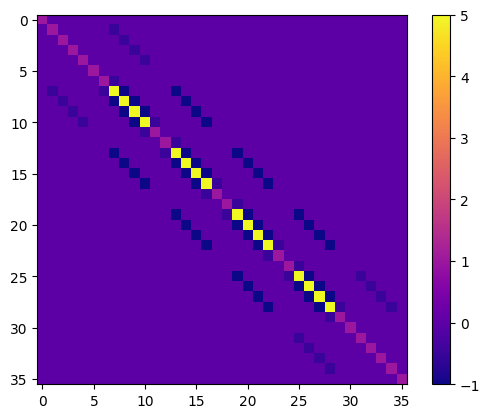

In [28]:
plt.imshow(A_symmetric, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()